In [19]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from rsq import AgglomerativeEnsemble
from rsq.helpers import stratified_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_moons

def exp(n, n_labeled, noise=0.1):
    accuracies = np.zeros(3)
    X, y = make_moons(n, noise=noise)
    
    at_least_1_per = False
    while not at_least_1_per:
        inds = np.random.choice(len(y), n_labeled, replace=False)
        if len(np.where(y[inds] == 1)[0]) > 0 and len(np.where(y[inds] == 1)[0]) < n_labeled:
            at_least_1_per=True

    y_ = -1 * np.ones(len(y))
    y_[inds] = y[inds]

    n_neighbors = int(np.math.ceil(np.math.log(n_labeled)))
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=n_neighbors, gem_p=16)

    clf.fit(X, y_)
    y_hat=clf.predict(X)
    accuracies[0] = (y == y_hat).mean()
    
    
    clf=SVC()
    clf.fit(X[inds], y[inds])
    y_hat=clf.predict(X)
    accuracies[1] = (y == y_hat).mean()
    
    clf=RandomForestClassifier()
    clf.fit(X[inds], y[inds])
    y_hat=clf.predict(X)
    accuracies[2] = (y == y_hat).mean()

    return accuracies

In [125]:
n_labeled_list = [2,4,8,16] 
condensed_func = lambda x: exp(100, x)

n_mc=180
n_cores=90

algos = ['AggClass', 'SVM (rbf)', 'Random Forest']

func_tuples = []
for n_labeled in n_labeled_list:
    for i in range(n_mc):
        func_tuples.append(n_labeled)
        
accuracies_list = Parallel(n_jobs=n_cores)(delayed(condensed_func)(x) for x in func_tuples)

In [126]:
accuracies=np.zeros((len(algos), len(n_labeled_list), n_mc))

for i in range(len(n_labeled_list)):
    for j in range(n_mc):
        accuracies[0, i, j] = accuracies_list[int(i*n_mc + j)][0]
        accuracies[1, i, j] = accuracies_list[int(i*n_mc + j)][1]
        accuracies[2, i, j] = accuracies_list[int(i*n_mc + j)][2]

0.87
0.74
0.75


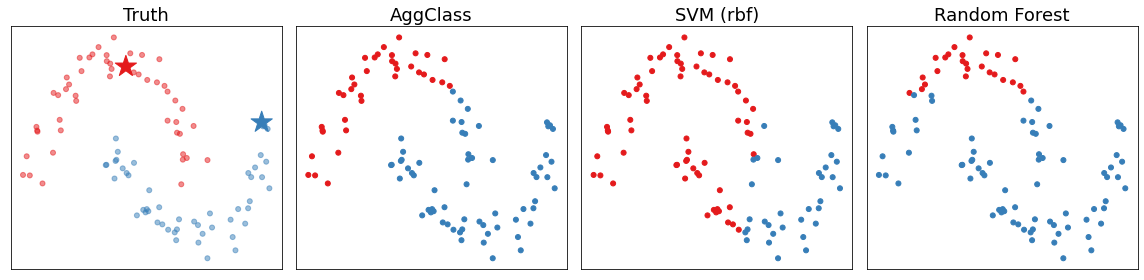

In [123]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
n_labeled=2

colors=sns.color_palette("Set1", n_colors=len(algos)+5)

fontsize=18

X,y = make_moons(100, noise=0.1)

at_least_1_per = False
while not at_least_1_per:
    inds = np.random.choice(len(y), n_labeled, replace=False)
    if len(np.where(y[inds] == 1)[0]) > 0 and len(np.where(y[inds] == 1)[0]) < n_labeled:
        at_least_1_per=True
        

y_ = -1 * np.ones(100)
y_[inds] = y[inds]

s=25
        
ax[0].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y.astype(int)], s=s, alpha=0.5)
ax[0].scatter(X[inds, 0], X[inds, 1], c=np.array(colors)[np.array([0,1])][y[inds].astype(int)], marker='*', s=500)
ax[0].set_title('Truth', fontsize=fontsize)

n_neighbors = int(np.math.ceil(np.math.log(n_labeled)))
clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=n_neighbors, gem_p=1, classes=np.array([0,1]))
clf.fit(X, y_)
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[1].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[1].set_title('AggClass', fontsize=fontsize)

clf=SVC()
clf.fit(X[inds], y[inds])
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[2].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[2].set_title('SVM (rbf)', fontsize=fontsize)

clf=RandomForestClassifier()
clf.fit(X[inds], y[inds])
y_hat=clf.predict(X)
print((y_hat == y).mean())
ax[3].scatter(X[:, 0], X[:, 1], c=np.array(colors)[np.array([0,1])][y_hat.astype(int)], s=s)
ax[3].set_title('Random Forest', fontsize=fontsize)


# for i, algo in enumerate(algos):
#     ax[4].scatter(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[i], label=algo)
#     ax[4].errorbar(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[i], yerr=np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))

#     for j, n_labeled in enumerate(n_labeled_list):
#         if j > 0:
#             continue
#         ax[4].scatter([n_labeled + (i-1)/2.5]*n_mc, accuracies[i, j], color=colors[i], s=1, alpha=1)
    
    
# ax[4].legend()
# ax[4].set_xlabel('# labeled samples')
# ax[4].set_title('Accuracy vs # labeled samples')

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])
    
# ax[4].set_yticks([0.7,0.8,0.9,1])
# ax[4].set_xticks(n_labeled_list)

plt.tight_layout()
plt.savefig('figures/moons_poc.pdf')